# Intro to clustering methods

The goal of the notebook is to explore 4 different clustering methods by use of clothes sales data. The notebook contains 7 chapters and introduction as listed below.
* Data preparation: regular cleaning
* Data analysis: fast look at Spearman dependencies
* Connectivity models, example: "hierarchical clustering" builds models based on distance connectivity.
* Centroid models, example: "k-means algorithm" represents each cluster by a single mean vector.
* Distribution models, example: "expectation-maximization algorithm" for modeling by use of statistical distributions.
* Density models: for example: "DBSCAN" defines clusters as connected dense regions in the data space.
* Clustering summary: I will group the results and compare

Below the list shows different clustering methods, data types in rows, methods in columns coming from [scikit](https://scikit-learn.org/stable/modules/clustering.htm) . I analyse 1st one which is centroid k-means, 5th is connectivity hierarchical with ward link, 6th connectivity hierarchical with average link, 7th density DBSCAN and last one disitrubtion EMA.

**Remark: relevant part of code hidden for clarity of notebook. Please click 'unhide' to see it.**

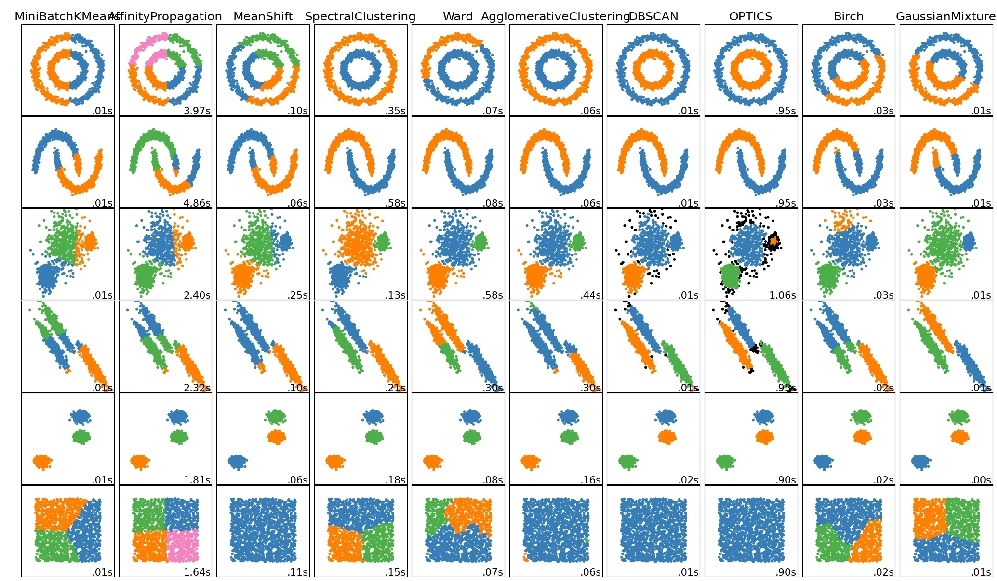

# Data preparation

I make very regular cleaning:
* detect the type of variable
    * categorical (ordinal)
    * categorical (nominal)
    * numeric
* Apply correction for NA's
* Apply scaling
* Transform nominal variables into dummy
* Analyse the existence of interesting interactions
* Simple features engineering

The data preparation is not granularly commented as it is not a point of this notebook. I focus on it in the different [job](https://www.kaggle.com/jjmewtw/prices-cleaning-analysis-estimation-in-stages) .

Read in libraries.

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from mlxtend.preprocessing import minmax_scaling
import scipy.cluster.hierarchy as sch
import mpl_toolkits.mplot3d.axes3d as p3
import seaborn as sns
from sklearn import metrics, mixture, cluster, datasets
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_moons
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from sklearn.neighbors import kneighbors_graph
from itertools import cycle, islice
import time
import warnings
print('Libraries correctly loaded')

Loading and naming the data.

In [ ]:
summer_products_path = "../input/summer-products-and-sales-in-ecommerce-wish/summer-products-with-rating-and-performance_2020-08.csv"
unique_categories_path = "../input/summer-products-and-sales-in-ecommerce-wish/unique-categories.csv"
unique_categories_sort_path = "../input/summer-products-and-sales-in-ecommerce-wish/unique-categories.sorted-by-count.csv"

summer_products = pd.read_csv(summer_products_path)
unique_categories = pd.read_csv(unique_categories_path)
unique_categories_sort = pd.read_csv(unique_categories_sort_path)

df = summer_products
print('Number of rows: '+ format(df.shape[0]) +', number of features: '+ format(df.shape[1]))

Identifying data type and checking NA's. Correction for NA's.

In [ ]:
C = (df.dtypes == 'object')
CategoricalVariables = list(C[C].index)
Integer = (df.dtypes == 'int64') 
Float   = (df.dtypes == 'float64') 
NumericVariables = list(Integer[Integer].index) + list(Float[Float].index)

Missing_Percentage = (df.isnull().sum()).sum()/np.product(df.shape)*100
print("The number of missing entries before cleaning: " + str(round(Missing_Percentage,2)) + " %")

df[NumericVariables]=df[NumericVariables].fillna(0)
df=df.drop('has_urgency_banner', axis=1) # 70 % NA's

df[CategoricalVariables]=df[CategoricalVariables].fillna('Unknown')
df=df.drop('urgency_text', axis=1) # 70 % NA's
df=df.drop('merchant_profile_picture', axis=1) # 86 % NA's

C = (df.dtypes == 'object')
CategoricalVariables = list(C[C].index)
Integer = (df.dtypes == 'int64') 
Float   = (df.dtypes == 'float64') 
NumericVariables = list(Integer[Integer].index) + list(Float[Float].index)

Missing_Percentage = (df.isnull().sum()).sum()/np.product(df.shape)*100
print("The number of missing entries after cleaning: " + str(round(Missing_Percentage,2)) + " %")
print("The number of categorical variables:" + str(len(CategoricalVariables)))
print("The number of numeric variables:" + str(len(NumericVariables)))

Identify ordinal variables. Only one ordinal: size of the cloth.

In [ ]:
Size_map  = {'NaN':1, 'XXXS':2,'Size-XXXS':2,'SIZE XXXS':2,'XXS':3,'Size-XXS':3,'SIZE XXS':3,
            'XS':4,'Size-XS':4,'SIZE XS':4,'s':5,'S':5,'Size-S':5,'SIZE S':5,
            'M':6,'Size-M':6,'SIZE M':6,'32/L':7,'L.':7,'L':7,'SizeL':7,'SIZE L':7,
            'XL':8,'Size-XL':8,'SIZE XL':8,'XXL':9,'SizeXXL':9,'SIZE XXL':9,'2XL':9,
            'XXXL':10,'Size-XXXL':10,'SIZE XXXL':10,'3XL':10,'4XL':10,'5XL':10}

df['product_variation_size_id'] = df['product_variation_size_id'].map(Size_map)
df['product_variation_size_id']=df['product_variation_size_id'].fillna(1)
OrdinalVariables = ['product_variation_size_id']
print(OrdinalVariables)

Correction for color variable. All color levels listed.

In [ ]:
Color_map  = {'NaN':'Unknown','Black':'black','black':'black','White':'white','white':'white','navyblue':'blue',
             'lightblue':'blue','blue':'blue','skyblue':'blue','darkblue':'blue','navy':'blue','winered':'red',
             'red':'red','rosered':'red','rose':'red','orange-red':'red','lightpink':'pink','pink':'pink',
              'armygreen':'green','green':'green','khaki':'green','lightgreen':'green','fluorescentgreen':'green',
             'gray':'grey','grey':'grey','brown':'brown','coffee':'brown','yellow':'yellow','purple':'purple',
             'orange':'orange','beige':'beige'}

df['product_color'] = df['product_color'].map(Color_map)
df['product_color']=df['product_color'].fillna('Unknown')
df['product_color'].unique()

Wrap all and prepare. Get rid of useless variables - all of them are perfectly unique like ID or remain in one level like currency.

In [ ]:
NominalVariables = [x for x in CategoricalVariables if x not in OrdinalVariables]
Lvl = df[NominalVariables].nunique()

ToDrop=['title','title_orig','currency_buyer', 'theme', 'crawl_month', 'tags', 'merchant_title','merchant_name',
              'merchant_info_subtitle','merchant_id','product_url','product_picture','product_id']
df = df.drop(ToDrop, axis = 1)
FinalNominalVariables = [x for x in NominalVariables if x not in ToDrop]

df_dummy = pd.get_dummies(df[FinalNominalVariables], columns=FinalNominalVariables)
print(ToDrop)

Scale and apply dumym modification for nominal variables. List all our variables.

In [ ]:
df_clean = df.drop(FinalNominalVariables, axis = 1)
df_clean = pd.concat([df_clean, df_dummy], axis=1)

NumericVariablesNoTarget = [x for x in NumericVariables if x not in ['units_sold']]
df_scale=df_clean
df_scale[NumericVariables] = minmax_scaling(df_clean, columns=NumericVariables)
print(FinalNominalVariables + NumericVariables + OrdinalVariables)

# Data Analysis

Simple look at Spearman correlation. Huge correlation between rating variable - what makes sense.

In [ ]:
SpearmanCorr = df.corr(method="spearman")
plt.figure(figsize=(10,10))
sns.heatmap(SpearmanCorr, vmax=.9, square=True)

# Hierarchical clustering

As the name, hierarchical clustering aims on building hierarchy of clusters. There are two basic approaches:
* bottom-up (agglomerative): each observations starts in its own clusters and pairs of clusters are merged as one moves up the hierarchy
* top-down (divisive): all observations start in one cluster, and splits are performed recursively as one moves down the hierarchy

Hierarchical clustering struggles quite a lot with complexity. The most popular one is hierarchical agglomerative clustering (HAC).

I will explore the first one as it is far the most popular. And in this case it is all about two topics: how to choose crrect number of clusters and how to get perfect link. The method issimple: first explore denrogram to find out optimal clusters number. Second just check all possible links. The choice is highly arbitrary and it depends what you really want from the given data set.

In [ ]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [ ]:
X = df_scale.values
dendrogram = sch.dendrogram(sch.linkage(X, method='ward'), truncate_mode='level', p=4)

We can easily settle the treshold line at the level of 50.000 and receive just 6 clusters.

In [ ]:
AWcluster = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward')
AWcluster.fit(df_scale)
AWlabels = AWcluster.labels_
AWcluster_fit = AWcluster.fit(X)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5), facecolor='w', edgecolor='k')
ax = p3.Axes3D(fig)
ax.view_init(15, 30)
for l in np.unique(AWlabels):
    ax.scatter(X[AWlabels == l, 0], X[AWlabels == l, 1], X[AWlabels == l, 2],color=plt.cm.jet(float(l) / np.max(AWlabels + 1)),s=20, edgecolor='k')
plt.title('Hierarchical: Agglomerative Clustering with ward link' )

plt.show()

In [ ]:
AAcluster = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='average')
AAcluster.fit(df_scale)
AAlabels = AAcluster.labels_
AAcluster_fit = AAcluster.fit(X)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5), facecolor='w', edgecolor='k')
ax = p3.Axes3D(fig)
ax.view_init(15, 30)
for l in np.unique(AAlabels):
    ax.scatter(X[AAlabels == l, 0], X[AAlabels == l, 1], X[AAlabels == l, 2],color=plt.cm.jet(float(l) / np.max(AAlabels + 1)),s=20, edgecolor='k')
plt.title('Hierarchical: Agglomerative Clustering with ward average' )

plt.show()

Difference is not big but I would go for ward link anyway as it seems to be clearer spearated. Number 6 seems to be correct value for this method.

# K-means clustering

The most popular clustering method which aims on searating groups by division of their variance. The K-means algorithm aims to choose centroids that minimise the inertia, or within-cluster sum-of-squares criterion. The assumption about inertia takes into account convexity what is not always a case, especially considering irregularly shaped manifolds. It is not normalized, so I usually run PCA before using k-means method.

In [ ]:
kmeans_kwargs = {"init": "random","n_init": 10,"max_iter": 300,"random_state": 42,}

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
   kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
   kmeans.fit(df_scale)
   sse.append(kmeans.inertia_)

plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

According to 'elbow method', just 4 clusters are enough. Fit it and check inertia.

In [ ]:
KMcluster = KMeans(init="random",n_clusters=4,n_init=10,max_iter=300,random_state=42)
KMcluster.fit(df_scale)
print('The inertia equals to:' + format(KMcluster.inertia_))
#print('The center of clusters are:' + format(KMcluster.cluster_centers_))

In [ ]:
KMcluster_fit = KMcluster.fit(df_scale)
KMlabels = KMcluster.labels_

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5), facecolor='w', edgecolor='k')
ax = p3.Axes3D(fig)
ax.view_init(15, 30)
for l in np.unique(KMlabels):
    ax.scatter(X[KMlabels == l, 0], X[KMlabels == l, 1], X[KMlabels == l, 2],color=plt.cm.jet(float(l) / np.max(KMlabels + 1)),s=20, edgecolor='k')
plt.title('Centroid: k-means clustering' )

plt.show()

The method seems to be more-less consistent with hierarchical one. Only difference is that hierarchical one proposed 6 clusters, k-means offered 4 of them. K-means seem to be more'stable' in certain way in this case.

# Expectation-maximization algorithm

The Gaussian Mixture Models (GMM) algorithm is an unsupervised learning algorithm since we do not know any values of a target feature. This method is slightly rarer and not so obvious but in many cases powerful. For more interested ones, the basis for this topic is Jensen's inequality, which is persistenly used by math professors to test students at first tutorials, nice description [here](https://www.python-course.eu/expectation_maximization_and_gaussian_mixture_models.php).

First, it;s improtant to say that GMM is ultimately generative model and it was not created for clustering but for the pdf definition. As the model is generative, it means that defines the probability distribution. Hence, we can mathematically find the optimal number of clusters for example by use of likelihood. 

In [ ]:
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)

GM_n_components = np.arange(1, 21)
GM_models = [mixture.GaussianMixture(n, covariance_type='full', random_state=0).fit(Xmoon) for n in GM_n_components]

plt.plot(GM_n_components, [m.bic(Xmoon) for m in GM_models], label='BIC')
plt.plot(GM_n_components, [m.aic(Xmoon) for m in GM_models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

Paradoxiacally, similar to elbow rule, but at least with use of statistic like AIC or BIC. For the simplicity, we will go for BIC min, so 6 clusters.

In [ ]:
GM_n_classes = 6 #len(np.unique(df_scale))

GMcluster = mixture.GaussianMixture(n_components=GM_n_classes, covariance_type='full')
GMcluster_fit = GMcluster.fit(df_scale)
GMlabels = GMcluster_fit.predict(df_scale)
print('Number of clusters: ' + format(len(np.unique(GMlabels))))

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5), facecolor='w', edgecolor='k')
ax = p3.Axes3D(fig)
ax.view_init(15, 30)
for l in np.unique(GMlabels):
    ax.scatter(X[GMlabels == l, 0], X[GMlabels == l, 1], X[GMlabels == l, 2],color=plt.cm.jet(float(l) / np.max(GMlabels + 1)),s=20, edgecolor='k')
plt.title('Expectation-maximization algorithm for clustering' )

plt.show()

# Density-based spatial clustering of applications with noise

What so-called DBSCAN exactly does is to find core samples of high density and expand clusters from them. Hence, the underlying concept is simple: find the high density areas and build cluster around, sounds logic.

In [ ]:
DBcluster= DBSCAN(eps=0.3, min_samples=10)
DBcluster_fit = DBcluster.fit(df_scale)
core_samples_mask = np.zeros_like(DBcluster_fit.labels_, dtype=bool)
core_samples_mask[DBcluster_fit.core_sample_indices_] = True
DBlabels = DBcluster_fit.labels_ 

In [ ]:
DB_n_clusters_ = len(set(DBlabels)) 
DB_n_noise_ = list(DBlabels).count(-1)
print('Estimated number of clusters: %d' % DB_n_clusters_)
print('Estimated number of noise points: %d' % DB_n_noise_)

Oke, the optimal number of clusters is between k-means and hierarchical methods.

In [ ]:
# Black removed and is used for noise instead.
unique_labels = set(DBlabels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [1, 0, 0, 0]

    class_member_mask = (DBlabels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=20)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=2)

plt.title('Density-based spatial clustering of applications with noise')
plt.show()

I remove noise to look at density centers. Majority of points identified as noise by the algorithm.

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5), facecolor='w', edgecolor='k')
ax = p3.Axes3D(fig)
ax.view_init(15, 30)
for l in range(0,4):
    ax.scatter(X[DBlabels == l, 0], X[DBlabels == l, 1], X[DBlabels == l, 2],color=plt.cm.jet(float(l) / np.max(DBlabels + 1)),s=50, edgecolor='k')
plt.title('Density-based spatial clustering with noise removed' )

plt.show()

A lot of noise around the density points. Remaining density centers are presented on second graph.

# Clustering summary

I plot 4 different clustering methods (hierarchical with two links: ward and average) using the format used by scikit team.

In [ ]:
clustering_algorithms = (
        ('K-means', KMcluster),
        ('Ward', AWcluster),
        ('Agglomerative', AAcluster),
        ('DBSCAN', DBcluster),
        ('Gaussian Mixture', GMcluster)
    )

plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,hspace=.01)

plot_num = 1

for name, algorithm in clustering_algorithms:
    
    t0 = time.time()   
    algorithm.fit(X)
        
    t1 = time.time()
    
    if hasattr(algorithm, 'labels_'):
        y_pred = algorithm.labels_.astype(np.int)
    else:
        y_pred = algorithm.predict(df_scale)
    
    plt.subplot(3, len(clustering_algorithms), plot_num)
    plt.title(name + ', Clusters = ' + format(len(set(y_pred))), size=18)    
    colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))      
    colors = np.append(colors, ["#000000"])
    plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])
    plt.xlim(0, 0.7)
    plt.ylim(0, 0.7)
    plt.xticks(())
    plt.yticks(())
    plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
            transform=plt.gca().transAxes, size=15,
            horizontalalignment='right')
    plot_num += 1
    
plt.show()

Looking how records are grouped, we observe:
* for k-means vast concentration in cluster 1, clusters 2nd and 3rd are also relevant but 0 seems to contain only absolutely extreme values
* hierarchical ward link also shows concentration in one cluster with 3 another relevant clusters and 2 extreme ones
* hierarchical average link is very similar to previous one but leads to move between cluster 1 and 2
* DBSCAN should be further calibrated, almost all points classified as noise
* Gaussian mixture gave me the same results as hierarchical ward link ! Remember that order is not relevant

In [ ]:
KMunique, KMcounts = np.unique(KMlabels, return_counts=True)
AWunique, AWcounts = np.unique(AWlabels, return_counts=True)
AAunique, AAcounts = np.unique(AAlabels, return_counts=True)
DBunique, DBcounts = np.unique(DBlabels, return_counts=True)
GMunique, GMcounts = np.unique(GMlabels, return_counts=True)
print('K-means distributed points: ' + format(dict(zip(KMunique, KMcounts))))
print('Hierarchical ward link distributed points: ' + format(dict(zip(AWunique, AWcounts))))
print('Hierarchical average link distributed points: ' + format(dict(zip(AAunique, AAcounts))))
print('DBSCAN distributed points: ' + format(dict(zip(DBunique, DBcounts))))
print('Gaussian Mixture distributed points: ' + format(dict(zip(GMunique, GMcounts))))